In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score

# 이미지 전처리를 위한 변환 정의
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 이미지 정규화
])

# 학습 데이터셋 로드
trainset = ImageFolder(root='C:/Users/USER/Desktop/Semester2/Statistical-ML/Project3_TeamProject/train_data',
                       transform=transform)

# DataLoader 설정 (trainset만)
train_loader = DataLoader(trainset, 
                          batch_size=32, 
                          shuffle=True,
                          num_workers=0  # Windows에서는 num_workers=0 권장
                         )

# 데이터 로드 테스트
images, labels = next(iter(train_loader))
print(f"Loaded batch size: {images.size()}, Labels: {labels.size()}")


Loaded batch size: torch.Size([32, 3, 32, 32]), Labels: torch.Size([32])


In [18]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### 데이터 구조 확인
* 총 4000개 이미지
* 이미지당 (채널, 가로, 세로) = (3, 32, 32)

In [19]:
labels_map = {k: v for v, k in trainset.class_to_idx.items()}

Epoch [1/10], Loss: 2.2234
Epoch [2/10], Loss: 1.8648
Epoch [3/10], Loss: 1.7505
Epoch [4/10], Loss: 1.6822
Epoch [5/10], Loss: 1.6422
Epoch [6/10], Loss: 1.6515
Epoch [7/10], Loss: 1.6201
Epoch [8/10], Loss: 1.5178
Epoch [9/10], Loss: 1.5371
Epoch [10/10], Loss: 1.4625


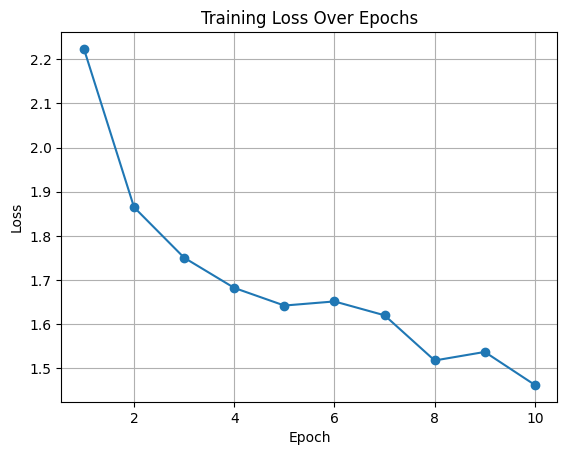

In [20]:
# CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # CIFAR-10 이미지 크기 가정 (32x32)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # (3, 32, 32)가 들어온다고 가정
        x = self.pool(F.relu(self.conv1(x)))  # 첫 번째 컨볼루션 + 풀링
        # 출력: (32, 16, 16)
        x = self.pool(F.relu(self.conv2(x)))  # 두 번째 컨볼루션 + 풀링
        # 출력: (64, 8, 8)
        x = self.pool(F.relu(self.conv3(x)))  # 세 번째 컨볼루션 + 풀링
        # 출력: (128, 4, 4)
        x = x.view(-1, 128 * 4 * 4)  # 평탄화
        # 첫번째 차원은 알아서 결정, 두번째 차원은 128*4*4
        x = F.relu(self.fc1(x))       # 첫 번째 전결합 계층
        x = self.fc2(x)               # 출력 계층
        return x
    
# 모델 초기화
model = SimpleCNN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 학습 함수 (손실 기록 포함)
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    loss_history = []  # 에포크별 손실 기록 리스트
    
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad() # 그래디언트 초기화
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        # 에포크별 평균 손실 기록
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}")
    
    return loss_history

# 모델 학습 및 손실 기록
epochs = 10
loss_history = train(model, train_loader, criterion, optimizer, epochs=epochs)

# 손실 그래프 시각화
plt.plot(range(1, epochs + 1), loss_history, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()
plt.show()